# Working with joins

## Download and install Spark

In [1]:
!ls -l

total 4
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data


In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


## Setup environment

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [7]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2020-12-19 15:27:58--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [             <=>    ]   1.59G  3.38MB/s    in 8m 5s   

2020-12-19 15:36:04 (3.36 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1709771456]

total 1890304
-rw-r--r--  1 root root 1709771456 Dec 19 12:14 'rows.csv?accessType=DOWNLOAD'
drwxr-xr-x  1 root root       4096 Dec  2 22:04  sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018  spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018  spark-2.3.1-bin-hadoop2.7.tgz


In [8]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

total 1890304
-rw-r--r--  1 root root 1709771456 Dec 19 12:14 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Dec  2 22:04 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz


In [9]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Joins

**Download police station data**

In [10]:
!wget -O police-station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
!ls -l

--2020-12-19 15:38:48--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police-station.csv’

police-station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2020-12-19 15:38:48 (858 MB/s) - ‘police-station.csv’ saved [5699]

total 1890316
-rw-r--r--  1 root root       5699 Aug 19  2019 police-station.csv
-rw-r--r--  1 root root 1709771456 Dec 19 12:14 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Dec  2 22:04 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz
drwxr-xr-x  2 root root       4096 Dec 19 15:36 spark-warehouse


In [37]:
ps = spark.read.csv('police-station.csv',header=True)
ps = ps.drop('ADDRESS','CITY','STATE', 'ZIP', 'WEBSITE', 'PHONE', 'FAX', 'TTY', 'X COORDINATE', 'Y COORDINATE','LATITUDE','LONGITUDE','LOCATION')
ps.show(5)

+------------+--------------+
|    DISTRICT| DISTRICT NAME|
+------------+--------------+
|           1|       Central|
|           6|       Gresham|
|          11|      Harrison|
|          16|Jefferson Park|
|Headquarters|  Headquarters|
+------------+--------------+
only showing top 5 rows



**The reported crimes dataset has only the district number. Add the district name by joining with the police station dataset**

In [12]:
rc.cache()
rc.count()

6753700

In [38]:
ps.select("DISTRICT").distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+



In [20]:
rc.select("District").distinct().show(30)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     005|
|     003|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     021|
|     002|
+--------+



In [21]:
from pyspark.sql.functions import lpad

In [22]:
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col, len, pad)
    Left-pad the string column to width `len` with `pad`.
    
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]
    
    .. versionadded:: 1.5



In [24]:
ps.select(lpad(col("DISTRICT"),3,"0")).show()

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 001|
|                 006|
|                 011|
|                 016|
|                 Hea|
|                 024|
|                 002|
|                 007|
|                 025|
|                 010|
|                 015|
|                 003|
|                 014|
|                 008|
|                 004|
|                 020|
|                 018|
|                 012|
|                 ",C|
|                 009|
+--------------------+
only showing top 20 rows



In [39]:
ps = ps.withColumn("format_district",lpad(col("DISTRICT"),3,"0"))
ps.show(5)

+------------+--------------+---------------+
|    DISTRICT| DISTRICT NAME|format_district|
+------------+--------------+---------------+
|           1|       Central|            001|
|           6|       Gresham|            006|
|          11|      Harrison|            011|
|          16|Jefferson Park|            016|
|Headquarters|  Headquarters|            Hea|
+------------+--------------+---------------+
only showing top 5 rows



In [41]:
rc.join(ps,rc.District == ps.format_district, "left_outer").show(30)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT| DISTRICT NAME|format_district|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+---------------+
|10224738|   

**What is the most frequently reported non-criminal activity?**

In [42]:
rc.select(col("Primary Type")).distinct().count()

36

In [45]:
rc.select(col("Primary Type")).distinct().orderBy(col("Primary Type")).show(36,truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [57]:
from pyspark.sql.functions import array_contains
nc = rc.filter((col("Primary Type") == "NON - CRIMINAL") | (col("Primary Type") == "NON-CRIMINAL") | (col("Primary Type") == "NON-CRIMINAL (SUBJECT SPECIFIED)") )

In [59]:
nc.groupBy("Description").count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |5    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



**Using a bar chart, plot which day of the week has the most number of reported crime.**

In [63]:
from pyspark.sql.functions import dayofweek, date_format

In [64]:
help(dayofweek)
help(date_format)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of the Java class `java.text.SimpleDateFormat` can be used.
    
    .. note:: Use when ever possible specialized functions like `year`. These benefit from a
        specialized implementation.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row

In [68]:
rc.select(col("Date"),dayofweek(col("Date")).alias("dayNo"), date_format(col("Date"),"E").alias("day")).show()

+-------------------+-----+---+
|               Date|dayNo|day|
+-------------------+-----+---+
|2015-09-05 13:30:00|    7|Sat|
|2015-09-04 11:30:00|    6|Fri|
|2018-09-01 00:01:00|    7|Sat|
|2015-09-05 12:45:00|    7|Sat|
|2015-09-05 13:00:00|    7|Sat|
|2015-09-05 10:55:00|    7|Sat|
|2015-09-04 18:00:00|    6|Fri|
|2015-09-05 13:00:00|    7|Sat|
|2015-09-05 11:30:00|    7|Sat|
|2016-05-01 00:25:00|    1|Sun|
|2015-09-05 14:00:00|    7|Sat|
|2015-09-05 11:00:00|    7|Sat|
|2015-09-05 03:00:00|    7|Sat|
|2015-09-05 12:50:00|    7|Sat|
|2015-09-03 13:00:00|    5|Thu|
|2015-09-05 11:45:00|    7|Sat|
|2015-09-05 13:30:00|    7|Sat|
|2015-07-08 00:00:00|    4|Wed|
|2015-09-05 09:55:00|    7|Sat|
|2015-09-05 12:35:00|    7|Sat|
+-------------------+-----+---+
only showing top 20 rows



In [70]:
rc.groupBy( date_format(col("Date"),"E").alias("day")).count().orderBy("count",ascending=False).show()

+---+-------+
|day|  count|
+---+-------+
|Fri|1017023|
|Wed| 973956|
|Tue| 968090|
|Sat| 965221|
|Thu| 964611|
|Mon| 952794|
|Sun| 912005|
+---+-------+



In [71]:
rc.groupBy( date_format(col("Date"),"E").alias("day")).count().collect()

[Row(day='Sun', count=912005),
 Row(day='Mon', count=952794),
 Row(day='Thu', count=964611),
 Row(day='Sat', count=965221),
 Row(day='Wed', count=973956),
 Row(day='Fri', count=1017023),
 Row(day='Tue', count=968090)]

In [78]:
dayOfWeek = [x[0] for x in rc.groupBy( date_format(col("Date"),"E").alias("day")).count().collect() ]
countAday = [x[1] for x in rc.groupBy( date_format(col("Date"),"E").alias("day")).count().collect() ]
dayOfWeek,countAday

(['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue'],
 [912005, 952794, 964611, 965221, 973956, 1017023, 968090])

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

cp = pd.DataFrame({"Day_Of_Week":dayOfWeek, "Count":countAday})
cp


,Day_Of_Week,Count
0,Sun,912005
1,Mon,952794
2,Thu,964611
3,Sat,965221
4,Wed,973956
5,Fri,1017023
6,Tue,968090


Text(0.5, 1.0, 'No Of reported crimes per day of the week from 2001 to present')

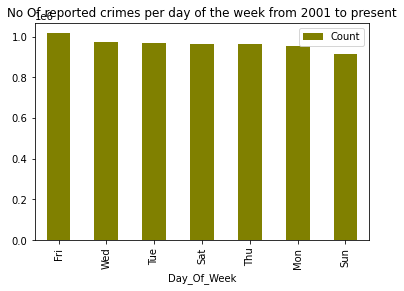

In [95]:
cp.sort_values("Count",ascending=False).plot(kind="bar",color="olive",x="Day_Of_Week",y="Count")
plt.xlabel = "Day Of Week"
plt.ylabel = "Count"
plt.title("No Of reported crimes per day of the week from 2001 to present")